In [1]:
%config InlineBackend.figure_format = 'retina'
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as plc
import pandas as pd
plt.rcParams['pdf.fonttype'] = 42

In [2]:
from src.CotrxMatrix import CotrxMatrix, combine_reps
from src.DMS_Profile import Genome
from src.dms_utils import weighted_moving_average, moving_average
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from src.pydscatter import dscatter_plot

def scale_mm(x, xmin, xmax):
    return((x - xmin) / (xmax - xmin))

def get_trajectories(mut):
    traj_mat = []
    ids = []
    for i, res in enumerate(genome_rrna.seq):
        if res in ['A', 'C']:
            x, y = mut.get_residue_txn(i, min_cov=800, binned=False)
            if x.shape and len(x) > 10:
                z = weighted_moving_average(x, y, 5)
                f = interp1d(x, z)
                x_hat = np.arange(min(x), max(x)+1, 1)
                y_hat = f(x_hat)
                y_hat = y_hat[y_hat != 0]
                traj_mat.append(y_hat)
                ids.append(i)
    return(traj_mat, ids)

def get_trajectories_no_interp(mut, ids):
    traj_mat_x = []
    traj_mat_y = []
    for i in ids:
        x, y = mut.get_residue_txn(i, min_cov=800, binned=False)
        traj_mat_x.append(x)
        traj_mat_y.append(y)
    return(traj_mat_x, traj_mat_y)

### MODEL FIT ###

# main model
def hyperbolic_decay(t, r0, t0, rsat):
    return r0 / (t + t0) + rsat
    
# first derivative (instantaneous rate of decay)
def inst_decay_rate(t, r0, t0):
    return -r0 / (t + t0)**2

# average decay rate
def avg_decay_rate(t1, t2, r0, t0):
    return ( -r0*( (1/(t1+t0))-(1/(t2+t0)) ) ) / (t2-t1)

# decay time from 1 to final state
def decay_time(lam, rsat):
    return -((1-rsat)/lam)

# decay time for fraction
def decay_time_frac(r0, t0, rsat, frac):
    rfrac = 1-frac+rsat*frac
    tfrac = (r0-t0*(rfrac-rsat)) / (rfrac-rsat)
    return(rfrac, tfrac)

# Figure 5a

In [3]:
genome_rrna = Genome('../data/genome/scer_chr_kan.FASTA', coords=(11, 451575, 458433), reverse=True)

In [4]:
# load matrices
min_cov = 800

wild_1 = CotrxMatrix('../data/processed/pro_wild_1_rRNA.pkl', 'wild_R1', genome_rrna.seq, '-')
wild_2 = CotrxMatrix('../data/processed/pro_wild_2_rRNA.pkl', 'wild_R2', genome_rrna.seq, '-')
wild_3 = CotrxMatrix('../data/processed/pro_wild_3_rRNA.pkl', 'wild_R3', genome_rrna.seq, '-')
wild_7 = CotrxMatrix('../data/processed/pro_wild_7_rRNA.pkl', 'wild_R7', genome_rrna.seq, '-')
wild_8 = CotrxMatrix('../data/processed/pro_wild_8_rRNA.pkl', 'wild_R8', genome_rrna.seq, '-')
wild = combine_reps([wild_1, wild_2, wild_3, wild_7, wild_8], 'wild')
wild.process()

/Users/leo/Documents/repos/CoSTseq/src/CotrxMatrix.py:445: RuntimeWarning: invalid value encountered in divide
  rea = (mut/cov)[filt_cov]
/Users/leo/Documents/repos/CoSTseq/src/CotrxMatrix.py:448: RuntimeWarning: invalid value encountered in divide
  rea = mut/cov


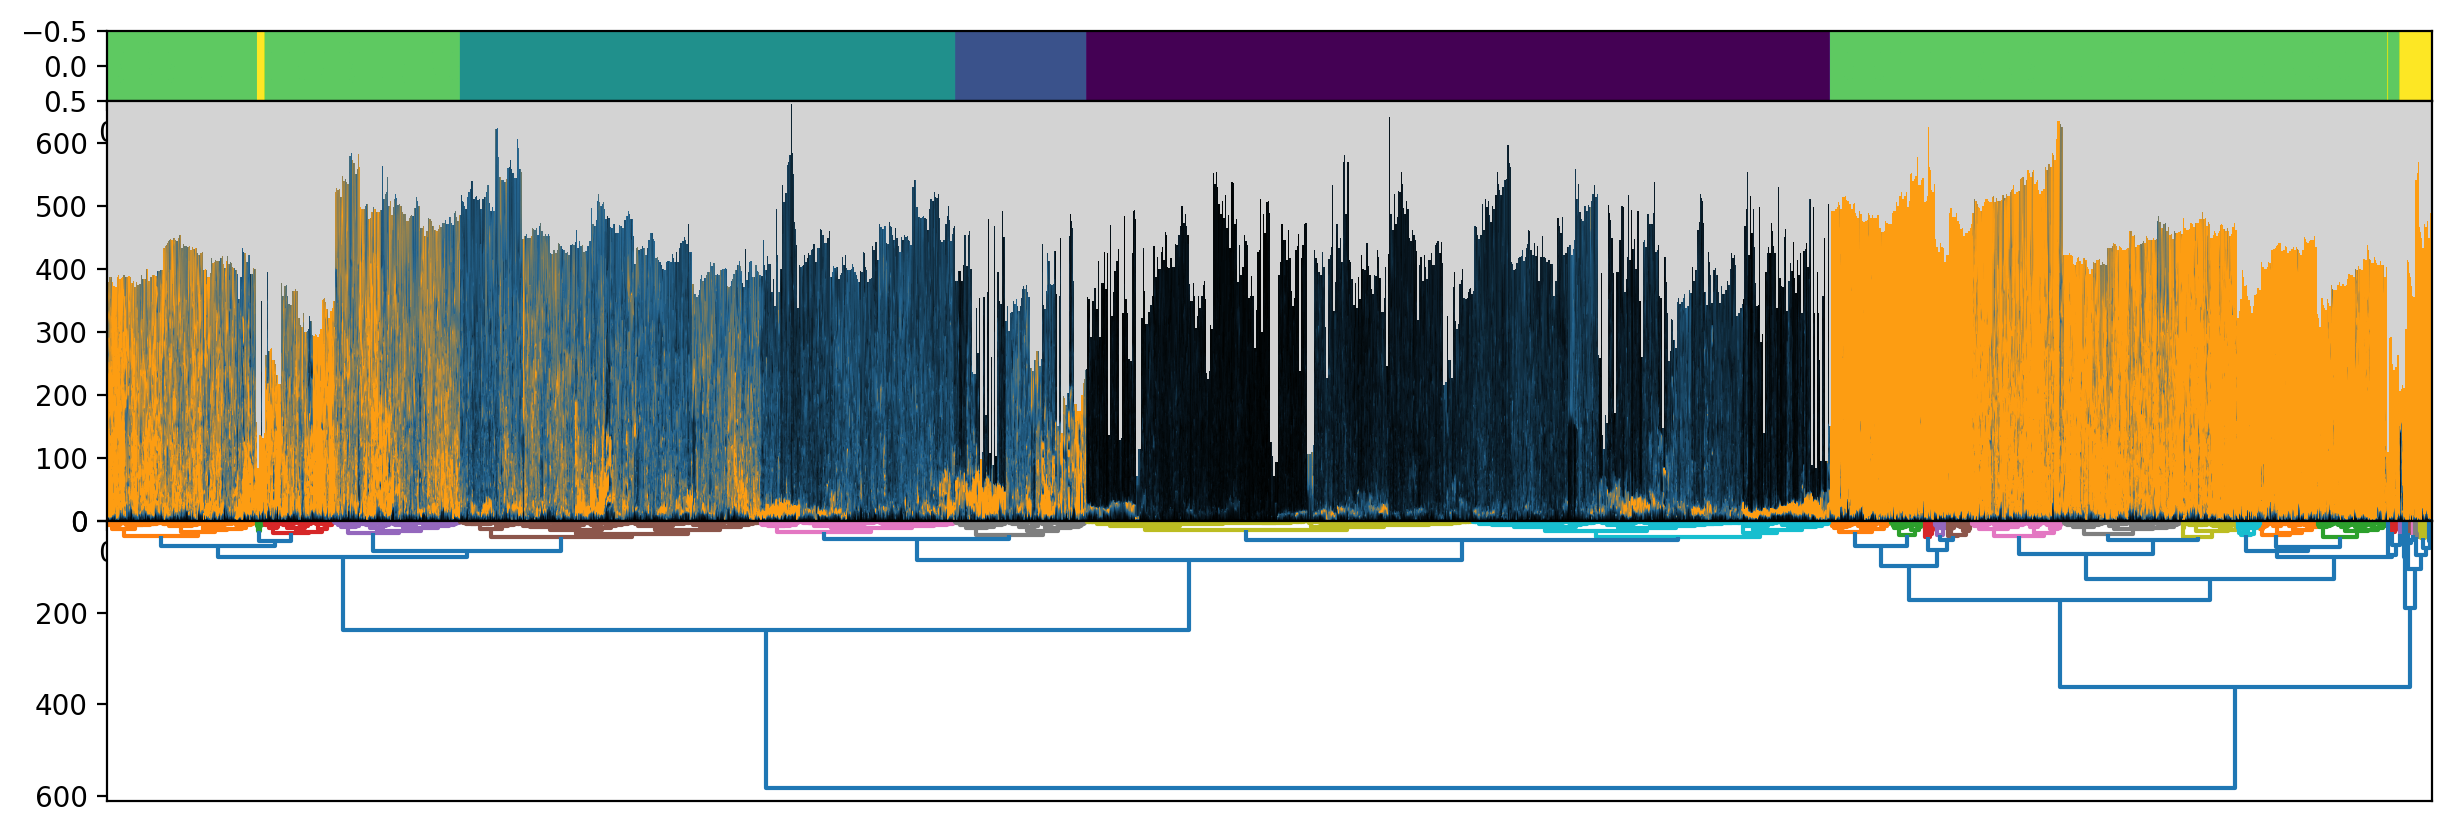

In [5]:
# hierarchical clustering
val_pad = 0
mut = wild
criterion = 'maxclust' # 'inconsistent', 'distance', 'maxclust', 'monocrit', 'maxclust_monocrit'
method = 'ward' # 'average', 'single', 'complete', 'weighted', 'centroid', 'median', 'ward'
trim_1 = 40
trim_2 = 25

traj_mat, ids = get_trajectories(mut)
traj_mat_pad = []
traj_mat_pad_nan = []
max_len = np.max([len(i) for i in traj_mat])
for traj in traj_mat:
    traj_pad = np.hstack([traj, (max_len-len(traj))*[val_pad]])
    traj_pad_nan = np.hstack([traj, (max_len-len(traj))*[np.nan]])
    
    traj_mat_pad.append(traj_pad)
    traj_mat_pad_nan.append(traj_pad_nan)

clust = linkage(traj_mat_pad, method=method, metric="euclidean")

# draw clustered trajectories
fig, axs = plt.subplots(3, 1, figsize=(15, 5), gridspec_kw={'height_ratios': [1, 6, 4]})
plt.subplots_adjust(hspace=0)

# draw dendrogram, retreive class labels for two levels of trimming
leaves = dendrogram(clust, orientation='bottom', color_threshold=trim_1, no_labels=True, ax=axs[2])
labels_lv1 = fcluster(clust, trim_1, criterion='distance')
labels_lv1_sort = np.array([labels_lv1[i] for i in leaves['leaves']])
labels_lv2 = fcluster(clust, trim_2, criterion='distance')
labels_lv2_sort = np.array([labels_lv2[i] for i in leaves['leaves']])

# manually merge similar classes
merged_classes = labels_lv1.copy()

# immediate pairing
merged_classes[labels_lv1==8] = 1
merged_classes[labels_lv1==9] = 1

# delayed pairing
merged_classes[labels_lv1==7] = 2

# mixed
merged_classes[labels_lv1==5] = 3
merged_classes[labels_lv1==6] = 3

# unpaired
merged_classes[labels_lv1==1] = 4
merged_classes[labels_lv1==3] = 4
merged_classes[labels_lv1==4] = 4
for i in range(10, 22):
    merged_classes[labels_lv1==i] = 4

# unassigned
merged_classes[labels_lv1==2] = 5
for i in range(22, 33):
    merged_classes[labels_lv1==i] = 5

merged_classes_sort = np.array([merged_classes[i] for i in leaves['leaves']])



# sort trajectories
traj_mat_pad_nan_sort = np.array([traj_mat_pad_nan[i] for i in leaves['leaves']])

for label in np.unique(merged_classes_sort):
    axs[0].imshow(np.reshape(merged_classes_sort, (1,3070)), aspect='auto')
    axs[0].text(np.mean(np.argwhere(merged_classes_sort==label)), 3.1, str(label), horizontalalignment='center')

# colormap
cmap = np.array(pd.read_csv('../cmap.txt', header=None))/255
cmap = plc.ListedColormap(cmap)
cmap.set_bad('lightgray', 1)

# draw ordered trajectories
axs[1].imshow(np.array(traj_mat_pad_nan_sort).T, aspect='auto', vmin=0, vmax=0.75, cmap=cmap)
axs[1].invert_yaxis()
axs[1].set_xlabel('Pol I position')
# axs[1].set_yticks([])
axs[1].sharex(axs[0])

plt.show()

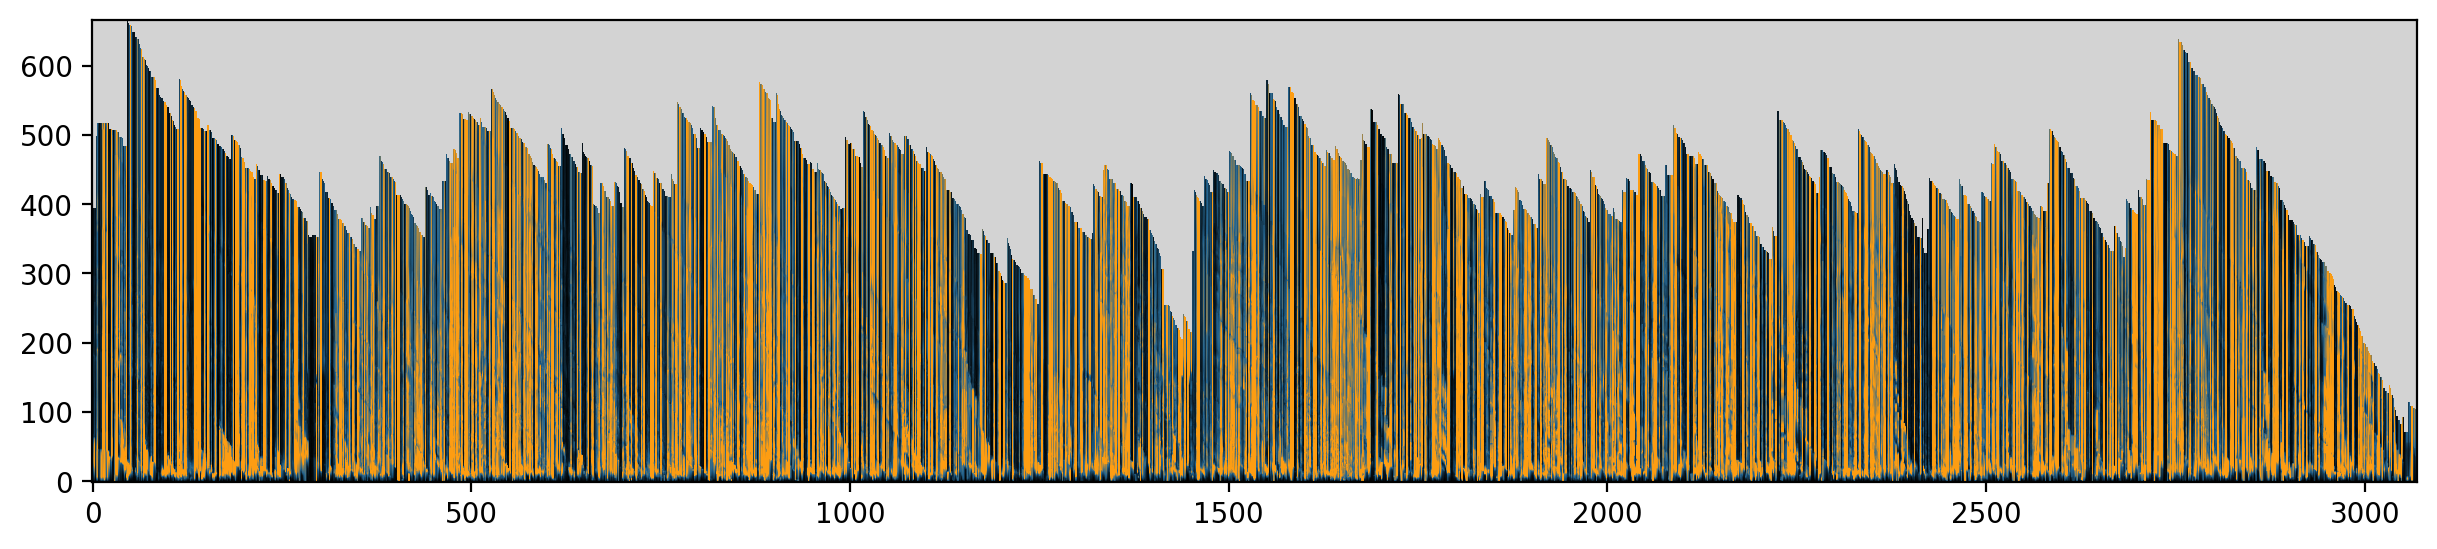

In [6]:
# draw unclustered trajectories
fig, axs = plt.subplots(figsize=(15, 3))

# draw ordered trajectories
axs.imshow(np.array(traj_mat_pad_nan).T, aspect='auto', vmin=0, vmax=0.75, cmap=cmap)
axs.invert_yaxis()

plt.show()

# Figure 5b

----------------------------
CLASS 1
t_0.9 =  25 nt
lam = -54.4 1/kb
t_decay =  18 nt
r_sat =  0.088
----------------------------
CLASS 2
t_0.9 =  422 nt
lam = -7.6 1/kb
t_decay =  132 nt
r_sat =  0.054
----------------------------
CLASS 3
t_0.9 =  79 nt
lam = -10.5 1/kb
t_decay =  96 nt
r_sat =  0.309
----------------------------
CLASS 4
t_0.9 =  2801 nt
lam = -0.6 1/kb
t_decay =  1810 nt
r_sat =  0.652


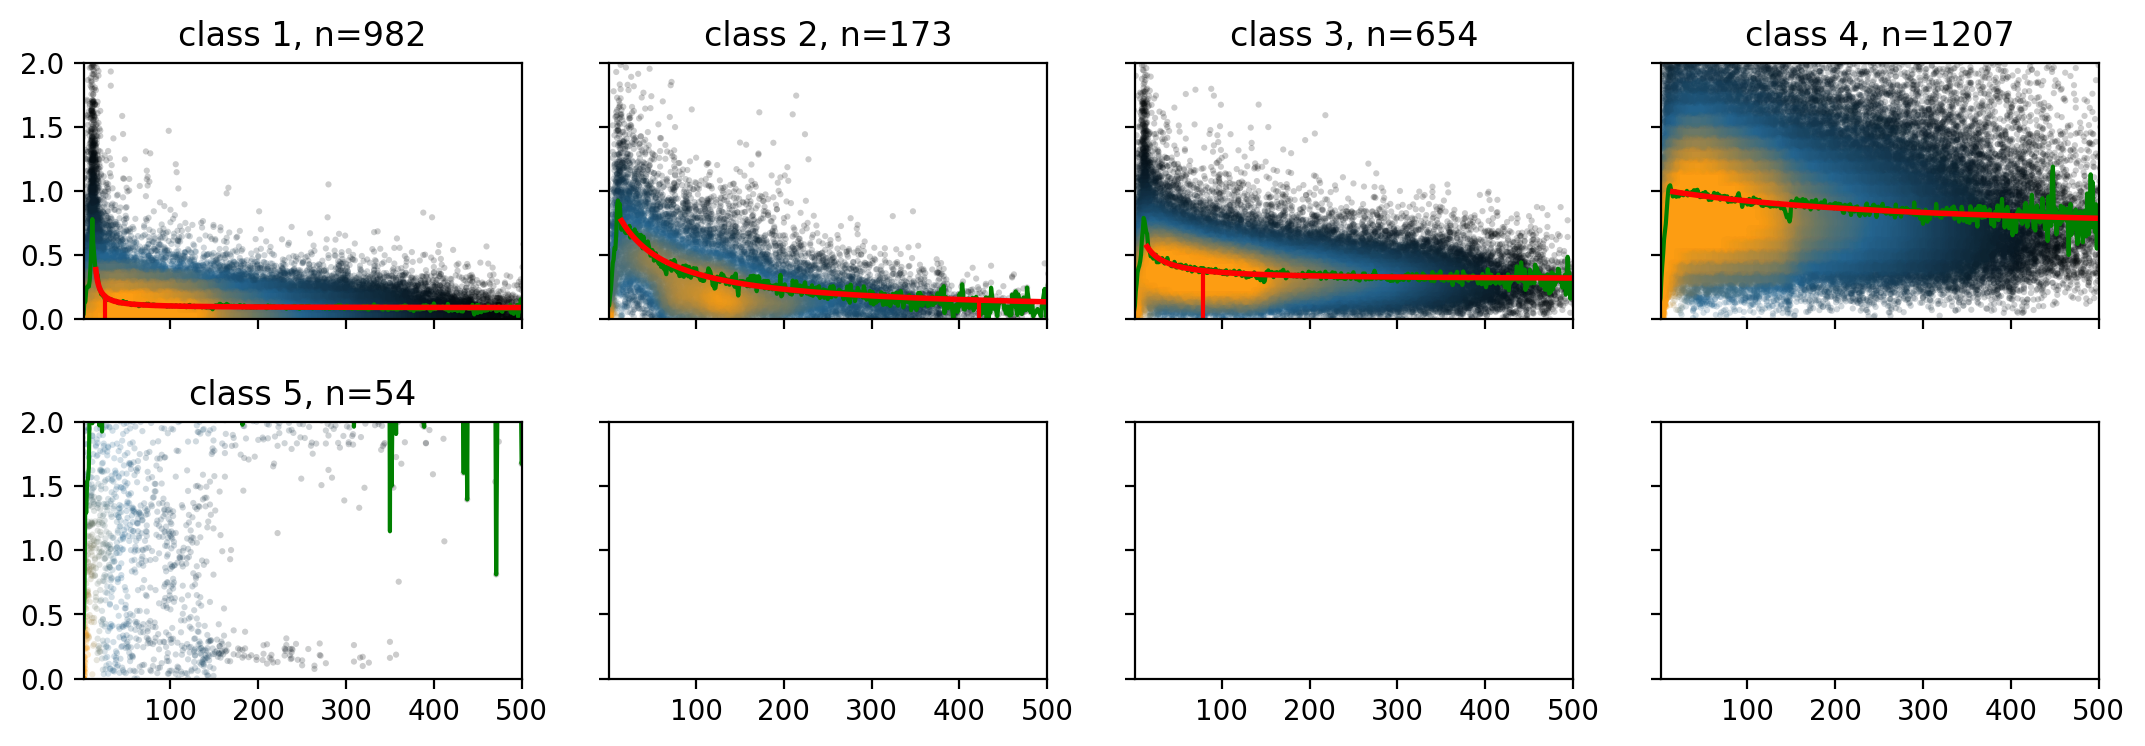

In [7]:
fig, axs = plt.subplots(2, 4, figsize=[13,4], sharex=True, sharey=True)
plt.subplots_adjust(hspace=0.4)
axs = axs.flatten()
np.random.seed(69)

traj_mat_t, traj_mat_r = get_trajectories_no_interp(wild, ids)

t_hat = np.arange(15, 500, 1)
paired_class = [1,2,3,4]
frac_folded = 0.90
for j, class_id in enumerate(np.unique(merged_classes)):

    t_traj = []
    r_traj = []
    for i in np.argwhere(merged_classes == class_id):
        t_traj.append(traj_mat_t[i[0]]-traj_mat_t[i[0]][0])
        r_traj.append(traj_mat_r[i[0]])
    t = np.hstack(t_traj)
    r = np.hstack(r_traj)
    
    dscatter_plot(t, r, ax=axs[j], lamb=30, order=False, markersize=5, edgecolors='none', alpha=0.2, cmap=cmap, vmax=0.8, rasterized=True)
    
    median = [np.mean(r[t==i]) for i in np.unique(t)]
    axs[j].plot(np.unique(t), median, '-g') 
    
    if class_id in paired_class:
        
        # Fit the hyperbolic decay model to the data
        params, covariance = curve_fit(hyperbolic_decay, t[t>=15], r[t>=15], maxfev=10000, p0=[4, 20, 0.05], bounds=[(-np.inf, -np.inf, -np.inf), (np.inf, np.inf, np.inf)])
        
        # Extract the fitted parameters
        r0, t0, rsat = params

        # Generate reactivity values from the fitted model
        r_hat = hyperbolic_decay(t_hat, r0, t0, rsat)
        
        # other params
        rfrac, tfrac = decay_time_frac(r0, t0, rsat, frac_folded)
        rfrac50, tfrac50 = decay_time_frac(r0, t0, rsat, 0.5)
        lam = avg_decay_rate(15, np.max([tfrac50, 16]), r0, t0)
        t_full_decay = decay_time(lam, 0)

        axs[j].plot(t_hat, r_hat, '-r', lw=2)
        axs[j].plot([tfrac, tfrac], [0, rfrac], '-r')
                
        
        print('----------------------------')
        print(f'CLASS {class_id}')
        print(f't_{frac_folded} = {tfrac: .0f} nt')
        print(f'lam = {1000*lam:.1f} 1/kb')
        print(f't_decay = {t_full_decay: .0f} nt')
        print(f'r_sat = {rsat: .3f}')
        
        
        
    axs[j].set_title(f"class {class_id}, n={np.sum(merged_classes == class_id)}")
    
plt.setp(axs, ylim=[0, 2], xlim=[1, 500], xscale='linear')
plt.show()

# Figure 5c

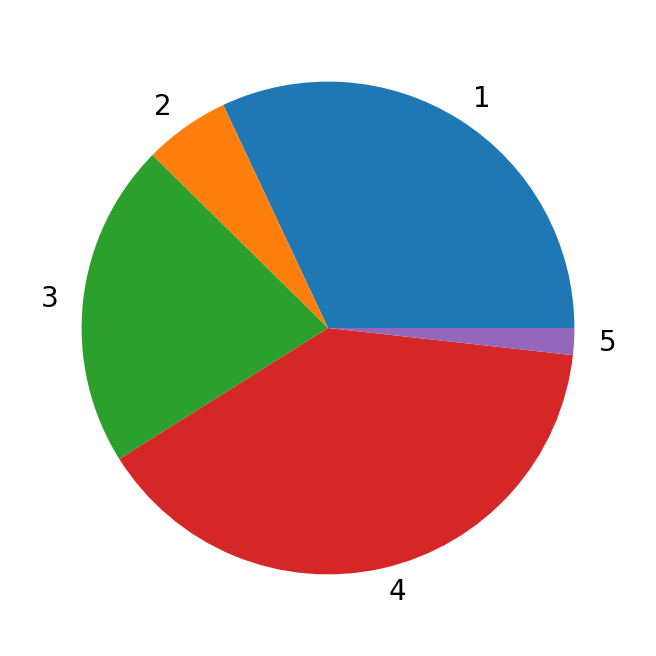

In [8]:
class_fractions = np.array([np.sum(merged_classes == class_id) for class_id in np.unique(merged_classes)])/len(merged_classes)

fig, axs = plt.subplots(figsize=(4,4))
axs.pie(class_fractions, labels=np.unique(merged_classes))
plt.show()

# Figure S5a

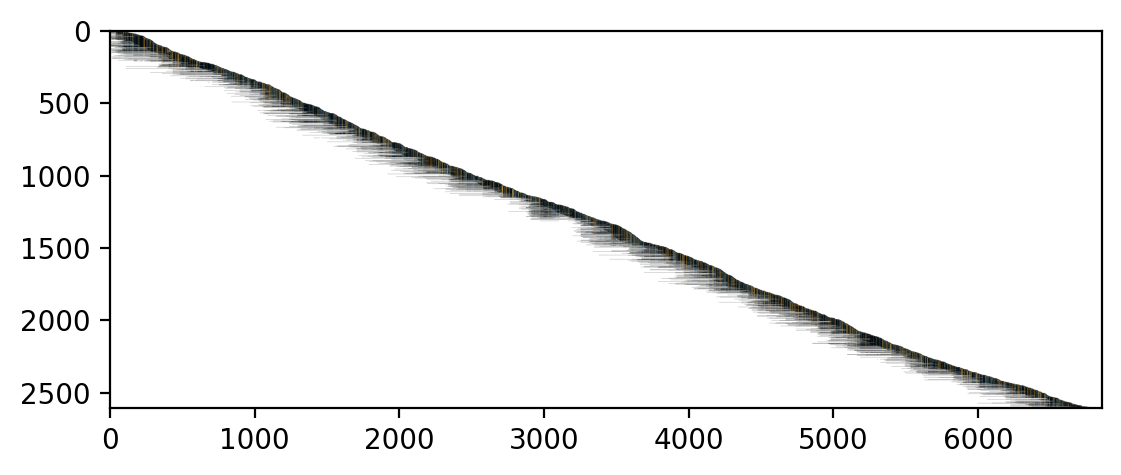

In [9]:
# save matrix as image
wild.save_to_img('matrix_image.png', filter_ac=False, cmap_loc='../cmap.txt')

# Figure S5b

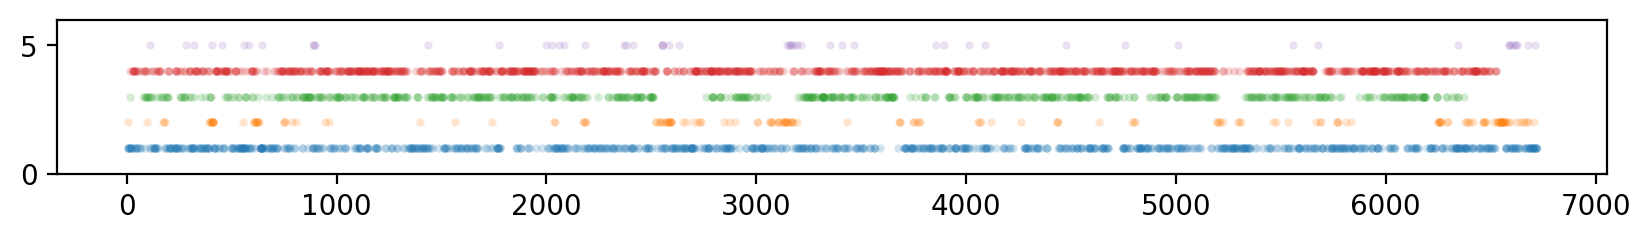

In [10]:
plt.figure(figsize=[10,1])
plt.plot(np.array(ids)[merged_classes==1], merged_classes[merged_classes==1], 'o', alpha=0.2, ms=3, markeredgecolor='none')
plt.plot(np.array(ids)[merged_classes==2], merged_classes[merged_classes==2], 'o', alpha=0.2, ms=3, markeredgecolor='none')
plt.plot(np.array(ids)[merged_classes==3], merged_classes[merged_classes==3], 'o', alpha=0.2, ms=3, markeredgecolor='none')
plt.plot(np.array(ids)[merged_classes==4], merged_classes[merged_classes==4], 'o', alpha=0.2, ms=3, markeredgecolor='none')
plt.plot(np.array(ids)[merged_classes>4], np.sum(merged_classes>4)*[5], 'o', alpha=0.2, ms=3, markeredgecolor='none')
plt.ylim(0, 6)
plt.show()